# Test: treatment structure and first-wave allocation

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rashomon.hasse import enumerate_policies
from first_wave import compute_boundary_probs, allocate_wave

We get our full lattice and then allocate the first wave of nodes according to their probability of lying on a partition boundary.

In [12]:
M = 2 # needs to be 2 for visualization
R = 5
H = 3 # sparsity for boundary probability, taken as given, TODO choice
n1 = 100 # total first wave sample size

In [13]:
# lattice - enumerate all R^M policies
policies = enumerate_policies(M, R)
K = len(policies)
print(f"Enumerated K = R^M = {K} policies (each as an M‐tuple).")

# compute boundary probabilities for each policy
boundary_probs = compute_boundary_probs(policies, R, H)

# allocate first-wave counts n1(v)
n1_alloc = allocate_wave(boundary_probs, n1)

Enumerated K = R^M = 25 policies (each as an M‐tuple).


In [14]:
# check allocation counts
total_alloc = int(n1_alloc.sum())
print(f"Should allocate {n1} total samples.")
print(f"Total allocated n1 across all policies: {total_alloc}")

Should allocate 100 total samples.
Total allocated n1 across all policies: 100


### set up DataFrame for visualization

In [16]:
# get v1 and v2 from policies, works for both list of tuples and array
v1 = [v[0] for v in policies]
v2 = [v[1] for v in policies]

df = pd.DataFrame({
    "v1": v1,
    "v2": v2,
    "boundary_prob": boundary_probs,
    "n1_alloc": n1_alloc
})

# set up in grid form. works also for non-uniform R
grid_probs = df.pivot(index="v1", columns="v2", values="boundary_prob")
grid_alloc = df.pivot(index="v1", columns="v2", values="n1_alloc")

### plot heatmaps for boundary probabilities and first-wave allocations

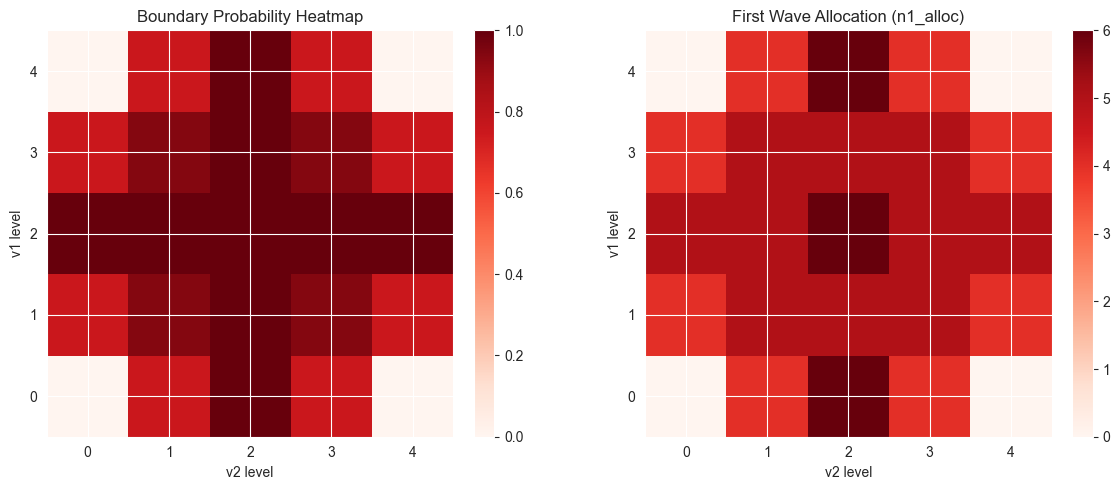

In [20]:
# plot heatmaps
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# boundary‐probability heatmap
im1 = axs[0].imshow(
    grid_probs.values,
    origin="lower",
    aspect="equal",
    vmin=grid_probs.values.min(),
    vmax=grid_probs.values.max(),
    cmap='Reds',
    interpolation='nearest'
)
axs[0].set_title("Boundary Probability Heatmap")
axs[0].set_xlabel("v2 level")
axs[0].set_ylabel("v1 level")

# if R was a list of different levels, use its max per‐feature to label ticks, otherwise just use R
if np.isscalar(R):
    max_v1 = R - 1
    max_v2 = R - 1
else:
    R_arr = np.array(R, dtype=int)
    max_v1 = R_arr[0] - 1
    max_v2 = R_arr[1] - 1

axs[0].set_xticks(np.arange(max_v2 + 1))
axs[0].set_yticks(np.arange(max_v1 + 1))
fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

# first‐wave allocation heatmap
im2 = axs[1].imshow(
    grid_alloc.values,
    origin="lower",
    aspect="equal",
    vmin=grid_alloc.values.min(),
    vmax=grid_alloc.values.max(),
    cmap='Reds',
    interpolation='nearest'
)
axs[1].set_title("First Wave Allocation (n1_alloc)")
axs[1].set_xlabel("v2 level")
axs[1].set_ylabel("v1 level")
axs[1].set_xticks(np.arange(max_v2 + 1))
axs[1].set_yticks(np.arange(max_v1 + 1))
fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Test: underlying causal model

In [21]:
from data_gen import get_beta_underlying_causal
from rashomon.hasse import enumerate_policies

#small M and R for quick checks
M = 3
R = 4

policies = enumerate_policies(M, R)

# current list of possibilities for causal model
kinds = [
    "bump_sin",
    "sin_prod",
    "poly",
    "gauss",
    "linear_only",
    "simple_interaction",
    "pairwise_sparse",
    "quadratic_form",
    "rbf_mixture",
    "neural_net_tanh",
    "poly_degree_3"
]

In [22]:
# loop over each kind, compute beta, print basic diagnostics
for kind in kinds:
    try:
        beta_vals = get_beta_underlying_causal(policies, M, R, kind=kind)
        print(f"Kind = {kind!r}")
        print(f"  Shape: {beta_vals.shape}")
        print(f"  First 5 values: {beta_vals[:5]!r}")
        print(f"  Min: {beta_vals.min():.6f}, Max: {beta_vals.max():.6f}, Mean: {beta_vals.mean():.6f}")
        print("-" * 60)
    except Exception as e:
        print(f"Kind = {kind!r} raised an error: {e}")
        print("-" * 60)

Kind = 'bump_sin' raised an error: Unknown kind='bump_sin'. Valid options:
  'bump_sin', 'sin_prod', 'poly', 'gauss',
  'linear_only', 'simple_interaction', 'pairwise_sparse', 'quadratic_form',
  'rbf_mixture', 'neural_net_tanh', 'poly_degree_3'.
------------------------------------------------------------
Kind = 'sin_prod'
  Shape: (64,)
  First 5 values: array([0., 0., 0., 0., 0.])
  Min: 0.000000, Max: 0.649519, Mean: 0.081190
------------------------------------------------------------
Kind = 'poly'
  Shape: (64,)
  First 5 values: array([0.        , 0.11111111, 0.44444444, 1.        , 0.11111111])
  Min: 0.000000, Max: 3.000000, Mean: 1.166667
------------------------------------------------------------
Kind = 'gauss'
  Shape: (64,)
  First 5 values: array([8.48182352e-05, 1.36415209e-03, 1.36415209e-03, 8.48182352e-05,
       1.36415209e-03])
  Min: 0.000085, Max: 0.352866, Mean: 0.052858
------------------------------------------------------------
Kind = 'linear_only'
  Shape: (